In [74]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# Paths
SHAP_VALUES_PATH = f'output/feature_importance_NCV/bottom10/country_shap_values_bottom10_2000_to_2020.csv'
LOOKUP_PATH = 'output/reference/indicator_lookup.csv'
OUTPUT_DIR = 'output/shap_clustering/'

# Number of features to consider
N_FEATURES = 10

# TSNE parameters
N_COMPONENTS = 2
PERPLEXITY = 1
LEARNING_RATE = 200
N_ITER = 1000

# DBSCAN parameters
EPS = 4
MIN_SAMPLES = 3

# Pull Data

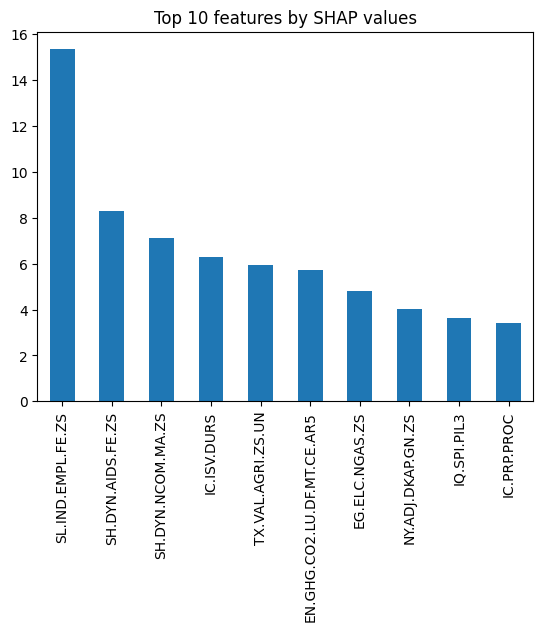

,Indicator Code,Indicator Name,Topic,Coarse_Topic
221,EG.ELC.NGAS.ZS,Electricity production from natural gas source...,Environment: Energy production & use,Environment & Climate
264,EN.GHG.CO2.LU.DF.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - ...,Climate,Environment & Climate
458,IC.ISV.DURS,Time to resolve insolvency (years),Private Sector & Trade: Business environment,Economy & Finance
462,IC.PRP.PROC,Procedures to register property (number),Private Sector & Trade: Business environment,Economy & Finance
521,IQ.SPI.PIL3,Statistical performance indicators (SPI): Pill...,Public Sector: Policy & institutions,Government & Governance
665,NY.ADJ.DKAP.GN.ZS,Adjusted savings: consumption of fixed capital...,Economic Policy & Debt: National accounts: Adj...,Economy & Finance
994,SH.DYN.AIDS.FE.ZS,Women's share of population ages 15+ living wi...,Health: Risk factors,Health
1000,SH.DYN.NCOM.MA.ZS,"Mortality from CVD, cancer, diabetes or CRD be...",Health: Mortality,Health
1191,SL.IND.EMPL.FE.ZS,"Employment in industry, female (% of female em...",Social Protection & Labor: Economic activity,Economy & Finance
1456,TX.VAL.AGRI.ZS.UN,Agricultural raw materials exports (% of merch...,Private Sector & Trade: Exports,Economy & Finance


In [76]:
df_shap = pd.read_csv(SHAP_VALUES_PATH)
df_shap_labels = df_shap[['Country_Code', 'Country_Name']]
df_shap_data = df_shap.drop(columns=['Country_Code', 'Country_Name'])
df_shap_pivot = df_shap_data.abs().sum(axis=0).sort_values(ascending=False).head(N_FEATURES)
top_features = df_shap_pivot.index.tolist()
df_shap_pivot.plot(kind='bar')
plt.title(f'Top {N_FEATURES} features by SHAP values')
plt.show()

lookup = pd.read_csv(LOOKUP_PATH)
lookup = lookup[lookup['Indicator Code'].isin(top_features)]
display(lookup)

# t-SNE

In [77]:
tsne = TSNE(n_components=N_COMPONENTS, perplexity=PERPLEXITY, n_iter=N_ITER, learning_rate=LEARNING_RATE)
df_tsne = tsne.fit_transform(df_shap_data[top_features])
df_tsne = pd.DataFrame(df_tsne, columns=[f'TSNE_{i+1}' for i in range(N_COMPONENTS)])
df_tsne

,TSNE_1,TSNE_2
0,-104.844498,11.015510
1,-40.692921,-44.754543
2,29.635479,25.684519
3,1.724205,-26.626150
4,81.983025,15.533163
...,...,...
205,47.366745,-20.169394
206,-81.118988,6.492724
207,-81.869568,4.182921
208,-66.477707,-21.804668


# DBSCAN Clustering

In [78]:
dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
df_tsne_clustered = df_tsne.copy()
df_tsne_clustered['Cluster'] = dbscan.fit_predict(df_tsne) + 1
df_tsne_clustered

# Visualize clusters
# Separate outliers (cluster 0) from other clusters
outliers = df_tsne_clustered[df_tsne_clustered['Cluster'] == 0]
clusters = df_tsne_clustered[df_tsne_clustered['Cluster'] > 0]

# Calculate overall range to ensure proper scaling
x_min, x_max = df_tsne_clustered['TSNE_1'].min(), df_tsne_clustered['TSNE_1'].max()
y_min, y_max = df_tsne_clustered['TSNE_2'].min(), df_tsne_clustered['TSNE_2'].max()
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
overall_range = max(x_max - x_min, y_max - y_min) * 1.1  # Add 10% padding

# Create figure
fig = go.Figure()

# Add outliers as black, smaller points
fig.add_trace(go.Scatter(
    x=outliers['TSNE_1'], 
    y=outliers['TSNE_2'],
    mode='markers',
    marker=dict(color='lightgrey', size=10),
    name='Outliers (Cluster 0)'
))

# Add regular clusters with original coloring
fig.add_trace(go.Scatter(
    x=clusters['TSNE_1'], 
    y=clusters['TSNE_2'],
    mode='markers',
    marker=dict(
        color=clusters['Cluster'],
        colorscale='Viridis',
        size=10,
        colorbar=dict(title='Cluster')
    ),
    name='Clusters'
))

# Update layout with fixed aspect ratio and proper bounds
fig.update_layout(
    title='DBSCAN Clustering on TSNE',
    xaxis=dict(
        title='TSNE_1',
        range=[x_center - overall_range/2, x_center + overall_range/2],
        constrain='domain'
    ),
    yaxis=dict(
        title='TSNE_2',
        range=[y_center - overall_range/2, y_center + overall_range/2],
        scaleanchor='x',
        scaleratio=1
    ),
    legend_title='Cluster Type',
    width=800,
    height=800
)

os.makedirs(OUTPUT_DIR, exist_ok=True)
fig.to_html(f'{OUTPUT_DIR}/dbscan_tsne_clusters.html')
fig.show()

# Calculate silhouette score
if len(set(df_tsne_clustered['Cluster'])) > 1:
    silhouette_avg = silhouette_score(df_tsne, df_tsne_clustered['Cluster'])
    print(f'Silhouette Score: {silhouette_avg:.2f}')
else:
    print('Silhouette Score: Not applicable (only one cluster found)')

# Add country names to the clustering results
df_shap_clustered = pd.concat([df_shap_labels, df_tsne_clustered], axis=1)
df_shap_clustered.to_csv('output/feature_importance_NCV/bottom10/country_shap_values_bottom10_2000_to_2020_clustered.csv', index=False)

Silhouette Score: 0.62


# Interactive Plot with Hover Labels

In [82]:
# Create an enhanced visualization with country labels and SHAP values on hover
df_plot = df_shap_clustered.copy()

# Add the top features' SHAP values to the dataframe
df_plot_with_shap = pd.concat([df_plot, df_shap_data[top_features]], axis=1)

# Separate outliers from clusters for different styling
plot_outliers = df_plot_with_shap[df_plot_with_shap['Cluster'] == 0]
plot_clusters = df_plot_with_shap[df_plot_with_shap['Cluster'] > 0]

# Create hover text with country names and SHAP values for important features
def create_hover_text(row):
    text = f"<b>{row['Country_Name']}</b><br>"
    # Add top 5 SHAP values (positive or negative) for this country
    shap_values = row[top_features].abs().sort_values(ascending=False).head(5)
    for feature in shap_values.index:
        actual_value = row[feature]  # Get the actual value (not absolute)
        indicator_name = lookup[lookup['Indicator Code'] == feature]['Indicator Name'].values[0] if len(lookup[lookup['Indicator Code'] == feature]) > 0 else feature
        shortened_name = indicator_name[:30] + '...' if len(indicator_name) > 30 else indicator_name
        text += f"{shortened_name}: {actual_value:.4f}<br>"
    return text

# Apply the hover text creation function
plot_outliers['hover_text'] = plot_outliers.apply(create_hover_text, axis=1)
plot_clusters['hover_text'] = plot_clusters.apply(create_hover_text, axis=1)

# Create interactive figure with hover text
interactive_fig = go.Figure()

# Add outliers with hover text
interactive_fig.add_trace(go.Scatter(
    x=plot_outliers['TSNE_1'], 
    y=plot_outliers['TSNE_2'],
    mode='markers',
    marker=dict(color='black', size=6, line=dict(color='white', width=1)),
    name='Outliers',
    text=plot_outliers['hover_text'],
    hoverinfo='text'
))

# Add clusters with hover text
interactive_fig.add_trace(go.Scatter(
    x=plot_clusters['TSNE_1'], 
    y=plot_clusters['TSNE_2'],
    mode='markers',
    marker=dict(
        color=plot_clusters['Cluster'],
        colorscale='Viridis',
        size=12,
        line=dict(color='white', width=1),
        colorbar=dict(title='Cluster')
    ),
    name='Clusters',
    text=plot_clusters['hover_text'],
    hoverinfo='text'
))

# Use the same bounds as the previous plot
interactive_fig.update_layout(
    title='DBSCAN Clustering of Countries by SHAP Values (Hover for Labels & SHAP Values)',
    xaxis=dict(
        title='TSNE_1',
        range=[x_center - overall_range/2, x_center + overall_range/2],
        constrain='domain'
    ),
    yaxis=dict(
        title='TSNE_2',
        range=[y_center - overall_range/2, y_center + overall_range/2],
        scaleanchor='x',
        scaleratio=1
    ),
    legend_title='Cluster Type',
    width=900,
    height=900,
    hovermode='closest'
)

interactive_fig.to_html(f'{OUTPUT_DIR}/dbscan_tsne_clusters_interactive.html')
interactive_fig.show()

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_75838/1533904927.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cj/3zyd4jkj3s1f2bnvnnc629300000gn/T/ipykernel_75838/1533904927.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# t-SNE Parameter Tuning

In [80]:
# def run_tsne_with_parameters(data, perplexities=[5, 10, 30, 50, 100], learning_rates=[10, 100, 200, 500, 1000], n_iter=1000):
#     """Run t-SNE with different parameter combinations and visualize results"""
#     results = []
    
#     fig = make_subplots(rows=len(perplexities), cols=len(learning_rates), 
#                       subplot_titles=[f'Perp={p}, LR={lr}' for p in perplexities for lr in learning_rates],
#                       shared_xaxes=True, shared_yaxes=True)
    
#     row_idx = 1
#     for perp in perplexities:
#         col_idx = 1
#         for lr in learning_rates:
#             print(f"Running t-SNE with perplexity={perp}, learning_rate={lr}")
#             # Run t-SNE with current parameters
#             tsne = TSNE(n_components=2, perplexity=perp, learning_rate=lr, n_iter=n_iter, random_state=42)
#             embeddings = tsne.fit_transform(data)
            
#             # Store results
#             results.append({
#                 'perplexity': perp,
#                 'learning_rate': lr,
#                 'embeddings': embeddings,
#                 'kl_divergence': tsne.kl_divergence_
#             })
            
#             # Add to subplot
#             fig.add_trace(
#                 go.Scatter(
#                     x=embeddings[:, 0],
#                     y=embeddings[:, 1],
#                     mode='markers',
#                     marker=dict(size=5),
#                     text=df_data_scaled_grouped_labels['Country Name'],
#                     name=f'p={perp}, lr={lr}'
#                 ),
#                 row=row_idx, col=col_idx
#             )
            
#             col_idx += 1
#         row_idx += 1
    
#     # Update layout
#     fig.update_layout(
#         height=300 * len(perplexities),
#         width=250 * len(learning_rates),
#         title_text="t-SNE Parameter Tuning",
#         showlegend=False
#     )
    
#     # Create a summary table of KL divergences
#     kl_df = pd.DataFrame([(r['perplexity'], r['learning_rate'], r['kl_divergence']) 
#                         for r in results], columns=['perplexity', 'learning_rate', 'kl_divergence'])
#     kl_pivot = kl_df.pivot(index='perplexity', columns='learning_rate', values='kl_divergence')
    
#     # Find the best parameters (lowest KL divergence)
#     best_params = kl_df.loc[kl_df['kl_divergence'].idxmin()]
    
#     return fig, kl_pivot, best_params, results

# # Run t-SNE parameter tuning with a lower perplexity range to avoid over-scattering
# tsne_fig, tsne_kl_table, best_tsne_params, tsne_results = run_tsne_with_parameters(
#     df_data_scaled_grouped,
#     perplexities=[i for i in range(1,50)],  # Lower perplexity range
#     learning_rates=[200, 500, 1000],     # Focused learning rates
#     n_iter=5000                   # Increased iterations for better convergence
# )

# tsne_fig.show()

# # Display KL divergence table
# print("\nKL Divergence by Parameter Combination:")
# display(tsne_kl_table)

# # Don't automatically use the lowest KL divergence - let's visually inspect results
# print(f"\nBest t-SNE parameters based on KL divergence: perplexity={best_tsne_params['perplexity']}, "
#       f"learning_rate={best_tsne_params['learning_rate']}, "
#       f"KL divergence={best_tsne_params['kl_divergence']:.4f}")

# # Let's also evaluate the visual quality of the embeddings
# print("\nNOTE: The lowest KL divergence doesn't always produce the best visualization.")
# print("Choose parameters that create distinct, well-separated clusters but not overly scattered points.")